In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os
from ot.sliced import sliced_wasserstein_distance as swd
from tqdm.auto import tqdm

from triangular_transport.distances.mmdfuse import mmdfuse

from triangular_transport.kernels.kernel_tools import (
    get_gaussianRBF,
    vectorize_kfunc,
    linear_kernel,
    get_sum_of_kernels,
    get_matern_5_2,
)

In [2]:
nsamps = 20000
train_dim = 50000
nx = ny = 33

hmala_root = "training_dataset"
chains = []
for i in tqdm(range(40)):
    hmala_dir = f"chain_{i:02d}"
    hmala_path = os.path.join(hmala_root, hmala_dir, "hmala_samples_grid.npy")
    hmala_samps_chain = np.load(hmala_path).reshape(nsamps, nx * ny)
    thinned_samps = hmala_samps_chain[::40, :]
    chains.append(thinned_samps)
hmala_samps = np.vstack(chains)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
import pickle

with open("hyperparam_results/iteration_0/best_hyperparams.pkl", "rb") as f:
    best_hyperparams0 = pickle.load(f)
if best_hyperparams0["activation"] == "gelu":
    print("This is gelu")

This is gelu


In [7]:
best_hyperparams0

{'activation': np.str_('gelu'),
 'batch_size': 247,
 'hidden_layer': 594,
 'interpolant': np.str_('trig_interpolant'),
 'interpolant_der': np.str_('trig_interpolant_der'),
 'num_hidden_layers': 5,
 'optimizer': np.str_('adamw'),
 'peak_value': 0.0004170174499}

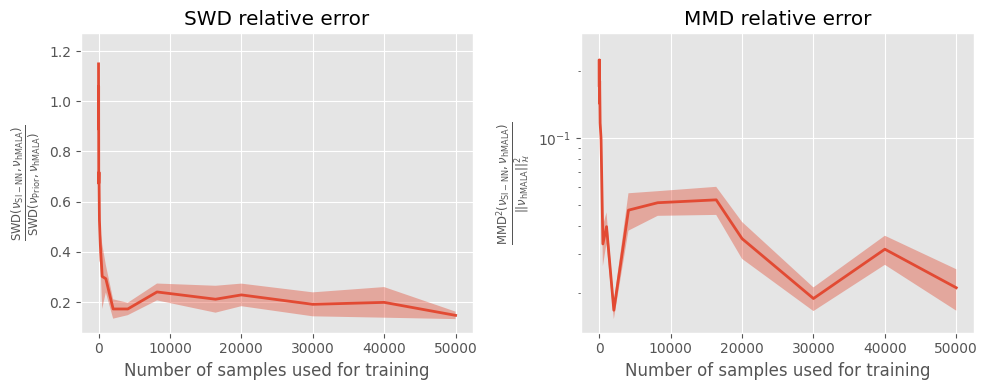

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

plt.style.use("ggplot")

sample_no_list = [2**i for i in range(1, 15)]
sample_no_list.append(20000)
sample_no_list.append(30000)
sample_no_list.append(40000)
sample_no_list.append(50000)

input_root = "convergence_results"
swd_list = []
mmd_list = []
for i in range(8):
    swd_list.append(
        np.load(
            os.path.join(input_root, f"run_{i:02d}/nn_sample_convergence_rel_error.npy")
        )
        .reshape(-1, 1)
        .T
    )
    mmd_list.append(
        np.load(os.path.join(input_root, f"run_{i:02d}/nn_sample_convergence.npy"))
        .reshape(-1, 1)
        .T
    )
swd_errors = np.vstack(swd_list)
mmd_errors = np.vstack(mmd_list)

swd_mean = np.mean(swd_errors, axis=0)
swd_std = np.std(swd_errors, axis=0)
mmd_mean = np.mean(mmd_errors, axis=0)
mmd_std = np.std(mmd_errors, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

ax[0].plot(sample_no_list, swd_mean, linewidth=2)
ax[0].set_title("SWD relative error")
ax[0].set_xlabel("Number of samples used for training")
ax[0].set_ylabel(
    r"$\frac{\mathrm{SWD}(\nu_{\mathrm{SI-NN}}, \nu_{\mathrm{hMALA}})}{\mathrm{SWD}(\nu_{\mathrm{Prior}}, \nu_{\mathrm{hMALA}})}$"
)
ax[0].fill_between(sample_no_list, swd_mean - swd_std, swd_mean + swd_std, alpha=0.4)

ax[1].plot(sample_no_list, mmd_mean, linewidth=2)
ax[1].set_title("MMD relative error")
ax[1].set_xlabel("Number of samples used for training")
ax[1].set_ylabel(
    r"$\frac{\mathrm{MMD}^2(\nu_{\mathrm{SI-NN}}, \nu_{\mathrm{hMALA}})}{||\nu_{\mathrm{hMALA}}||_\mathcal{H}^2}$"
)
ax[1].fill_between(sample_no_list, mmd_mean - mmd_std, mmd_mean + mmd_std, alpha=0.4)
ax[1].set_yscale("log")

plt.tight_layout()

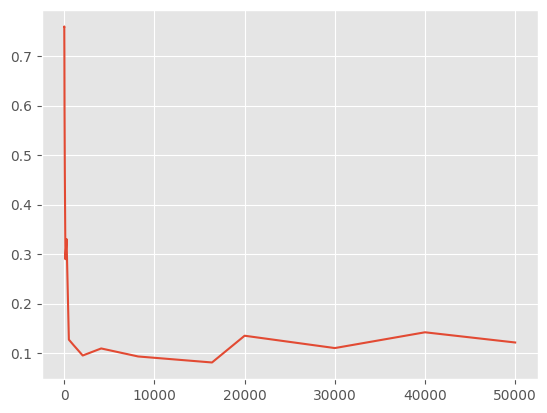

In [3]:
incumbent_loss = np.load("hyperparam_results/incumbent_loss.npy")
plt.plot(sample_no_list, incumbent_loss)

In [26]:
swd_mean

array([1.14912699, 1.0538579 , 0.88928439, 1.05985951, 0.67283165,
       0.71743196, 0.52555791, 0.42669925, 0.30191441, 0.29289721,
       0.17222795, 0.17227575, 0.24008237, 0.21115248, 0.22832935,
       0.19079459, 0.19855789, 0.14677981])

In [15]:
swd_list[0].shape

(18, 1)

In [ ]:
us = (np.load(os.path.join(hmala_root, "parameters_delta.npy")))[:train_dim, :].reshape(
    train_dim, nx * ny
)
mean_us = us.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [4]:
us.shape

(50000, 1089)

In [ ]:
u_samps0 = np.load(os.path.join("convergence_results/run_00", "u_samps_0.npy"))
jnp.exp(-jnp.sum((u_samps0[0] - u_samps0[2]) ** 2) / (2 * 5.0**2))

Array(0.18466616, dtype=float32)

In [ ]:
def median_heuristic_sigma_jax(X, Y=None, max_points=5000, seed=0):
    X = jnp.asarray(X).reshape(X.shape[0], -1)
    if Y is not None:
        Y = jnp.asarray(Y).reshape(Y.shape[0], -1)
        Z = jnp.concatenate([X, Y], axis=0)
    else:
        Z = X

    n = Z.shape[0]
    if n > max_points:
        idx = jax.random.choice(
            jax.random.PRNGKey(seed), n, (max_points,), replace=False
        )
        Z = Z[idx]

    a2 = jnp.sum(Z * Z, axis=1, keepdims=True)
    D2 = a2 + a2.T - 2.0 * (Z @ Z.T)
    D2 = jnp.triu(D2, k=1)  # zero elsewhere
    D = jnp.sqrt(jnp.clip(D2[D2 > 0], a_min=0.0))
    sigma = jnp.median(D)
    return float(sigma)


def gamma_from_sigma_jax(sigma):
    return 1.0 / (2.0 * (sigma**2))


sigma = median_heuristic_sigma_jax(us)
gamma = gamma_from_sigma_jax(sigma)
print(f"This is the median heuristic bandwidth: {gamma}")

2025-10-22 19:42:09.991878: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


This is the median heuristic bandwidth: 0.030763771874723837


In [6]:
input_root = "convergence_results/run_00"
input_root2 = "convergence_results_sde/run_00"
input_dir = os.path.join(input_root, "nn_sample_convergence_rel_error.npy")
input_dir2 = os.path.join(input_root2, "nn_sample_convergence_rel_error.npy")

u0_pca = np.load(os.path.join(input_root, "u_samps_0.npy"))
u1_pca = np.load(os.path.join(input_root, "u_samps_1.npy"))
rel_error_array = np.load(input_dir)
rel_error_array_sde = np.load(input_dir2)
sample_no_list = [2**i for i in range(1, 15)]
sample_no_list.append(20000)
sample_no_list.append(30000)
sample_no_list.append(40000)
sample_no_list.append(50000)

In [7]:
sample_no_list

[2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 1024,
 2048,
 4096,
 8192,
 16384,
 20000,
 30000,
 40000,
 50000]

In [8]:
rel_error_array_sde

array([1.01421066e+17, 3.50497811e+13, 8.11118713e+02,            nan,
       3.75108378e+15, 6.07895552e+10, 4.62736816e+01, 9.15200958e+01,
       1.81992462e+02, 3.45174384e+00, 5.32997549e-01, 4.15962785e-01,
       3.37400734e-01, 2.38901541e-01, 1.37920350e-01, 1.14916638e-01,
       1.89721227e-01, 1.62411287e-01])

In [14]:
sample_no_list[6:]

[128, 256, 512, 1024, 2048, 4096, 8192, 16384, 20000, 30000, 40000, 50000]

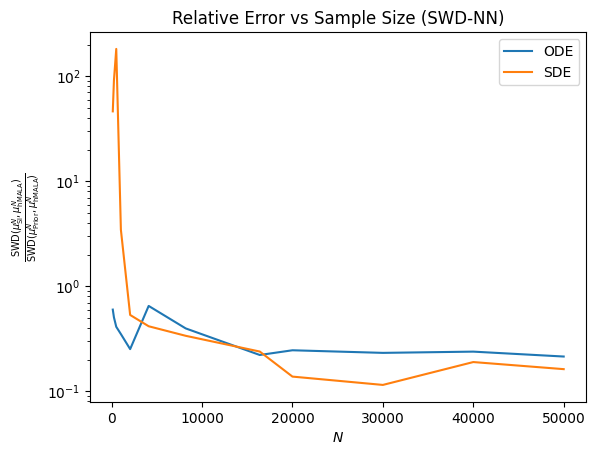

In [16]:
plt.plot(sample_no_list[6:], rel_error_array[6:], label="ODE")
plt.plot(sample_no_list[6:], rel_error_array_sde[6:], label="SDE")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel(r"$N$")
plt.ylabel(
    r"$\frac{\mathrm{SWD}(\mu^N_{\mathrm{SI}}, \mu^N_{\mathrm{hMALA}})}{\mathrm{SWD}(\mu^N_{\mathrm{Prior}}, \mu^N_{\mathrm{hMALA}})}$"
)
plt.title("Relative Error vs Sample Size (SWD-NN)")
plt.legend()

In [16]:
len(sample_no_list)

18

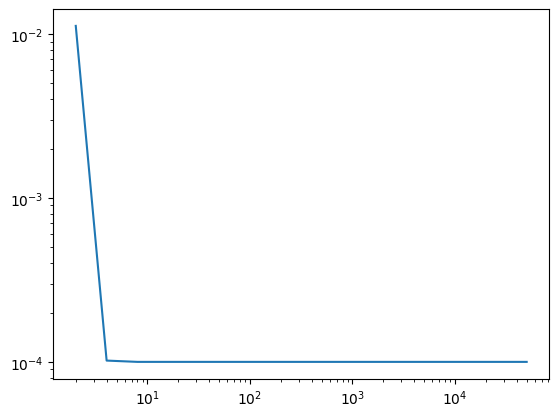

In [15]:
plt.plot(sample_no_list, mmd_array_nn)
plt.yscale("log")
plt.xscale("log")

0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


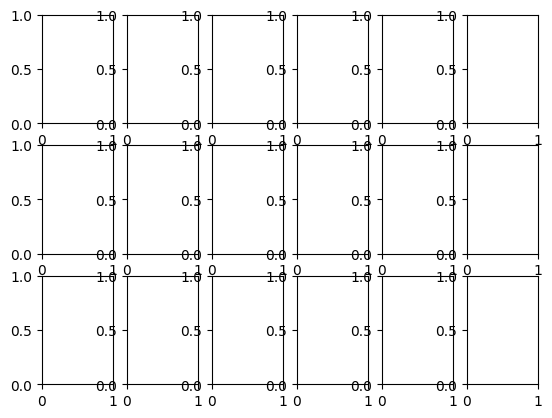

In [18]:
fig, ax = plt.subplots(3, 6)

for i in range(len(ax)):
    for j in range(len(ax[0, :])):
        print(j)

In [3]:
rel_error_array

array([4.94771367e+04, 1.34639803e-03, 1.19113931e-12, 8.47032405e-14,
       8.47032405e-14, 8.47032405e-14, 8.47032405e-14, 8.47032405e-14,
       8.47032405e-14, 8.47032405e-14, 8.47032405e-14, 8.47032405e-14,
       8.47032405e-14, 8.47032405e-14, 8.47032405e-14, 8.47032405e-14,
       8.47032405e-14, 8.47032405e-14])

In [21]:
# u0_pca = pca_encode(u_samps_0)
# u1_pca = pca_encode(u_samps_1)
hmala_pca = pca_encode(hmala_samps)

In [36]:
np.allclose(u0_pca, u1_pca)

False

In [ ]:
np.linalg.norm(u1_pca - u0_pca)

np.float32(6240.0024)

: 

In [ ]:
ker = get_gaussianRBF(gamma)
ker = vectorize_kfunc(ker)


@jax.jit
def get_kme(X, Y):
    return (jnp.mean(ker(X, X)) - jnp.mean(ker(Y, Y))) ** 2 / (jnp.mean(ker(Y, Y))) ** 2


@jax.jit
def MMD(X, Y):
    return jnp.mean(ker(X, X)) + jnp.mean(ker(Y, Y)) - 2 * jnp.mean(ker(X, Y))

In [23]:
swd(hmala_pca, u0_pca, n_projections=100)

np.float64(6.4404133912890975)

In [24]:
swd(hmala_pca, u1_pca, n_projections=100)

np.float64(0.5394934825902978)

In [25]:
random_selections = np.random.choice(20000, 1000)
random_hmala_samps = hmala_pca[random_selections, :]
mask = np.ones(len(hmala_samps), dtype=bool)
mask[random_selections] = False
left_hmala_samps = hmala_pca[mask, :]
MMD(random_hmala_samps, left_hmala_samps)

Array(0.00111655, dtype=float32)

In [ ]:
swd(
    np.mean(u0_pca, axis=0).reshape(-1, 1),
    np.mean(hmala_pca, axis=0).reshape(-1, 1),
    n_projections=10,
)

np.float64(2.7294034618179417)

In [27]:
MMD(np.mean(u0_pca, axis=0), np.mean(hmala_pca, axis=0))

Array(0.08003344, dtype=float32)

In [28]:
MMD(np.mean(u0_pca, axis=0), np.mean(u1_pca, axis=0))

Array(0.0544721, dtype=float32)

In [29]:
MMD(np.mean(u1_pca, axis=0), np.mean(hmala_pca, axis=0))

Array(0.05451075, dtype=float32)

In [30]:
MMD(u1_pca, hmala_pca)

Array(0.0001, dtype=float32)

In [31]:
MMD(u0_pca, hmala_pca)

Array(0.0001, dtype=float32)

In [32]:
MMD(u0_pca, u1_pca)

Array(0.0001, dtype=float32)

In [ ]:
print(f"This is the MMD for the large model against h-MALA: {MMD(u1_pca, hmala_pca)}")
print(f"This is the MMD for the small model against h-MALA: {MMD(u0_pca, hmala_pca)}")
print(
    f"This is the MMD for the large model against the small model: {MMD(u0_pca, u1_pca)}"
)

This is the MMD for the large model against h-MALA: 0.00010000001202570274
This is the MMD for the small model against h-MALA: 0.00010000001202570274
This is the MMD for the large model against the small model: 9.999999747378752e-05


In [ ]:
print(
    f"This is the relative error between the large model and h-MALA: {get_kme(u1_pca, hmala_pca)}"
)
print(
    f"This is the relative error between the small model and h-MALA: {get_kme(u0_pca, hmala_pca)}"
)
print(
    f"This is the relative error between the small and large model: {get_kme(u0_pca, u1_pca)}"
)

This is the relative error between the large model and h-MALA: 8.470324051532141e-14
This is the relative error between the small model and h-MALA: 8.470324051532141e-14
This is the relative error between the small and large model: 0.0


In [ ]:
@jax.jit
def one_kme(X, Y):
    return jnp.mean(ker(X, Y))


print(f"This is the kernel mean embedding of hmala: {one_kme(hmala_pca, hmala_pca)}")
print(f"This is the kernel mean embedding of large model: {one_kme(u1_pca, u1_pca)}")
print(f"This is the kernel mean embedding of small model: {one_kme(u0_pca, u0_pca)}")

This is the kernel mean embedding of hmala: 5.0000013288808987e-05
This is the kernel mean embedding of large model: 4.999999873689376e-05
This is the kernel mean embedding of small model: 4.999999873689376e-05


In [131]:
20000 / 500

40.0

In [130]:
500 * 80

40000

In [104]:
mmdfuse(u0_pca[:10000], hmala_pca[:10000], jax.random.key(42))[0]

Array(0.31176814, dtype=float32)

In [105]:
mmdfuse(u1_pca[:10000], hmala_pca[:10000], jax.random.key(42))[0]

Array(0.14785312, dtype=float32)

In [106]:
mmdfuse(u1_pca[:10000], u0_pca[:10000], jax.random.key(42))[0]

Array(0.42685854, dtype=float32)

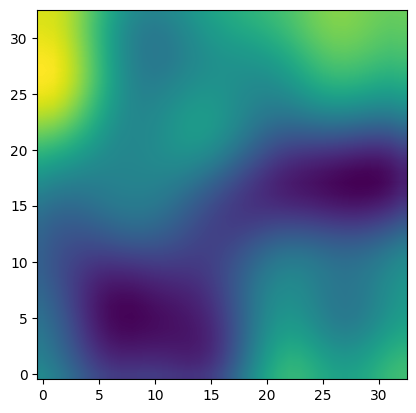

In [ ]:
plt.imshow(
    np.mean(pca_decode(u0_pca), axis=0).reshape(nx, ny),
    origin="lower",
    interpolation="bilinear",
)

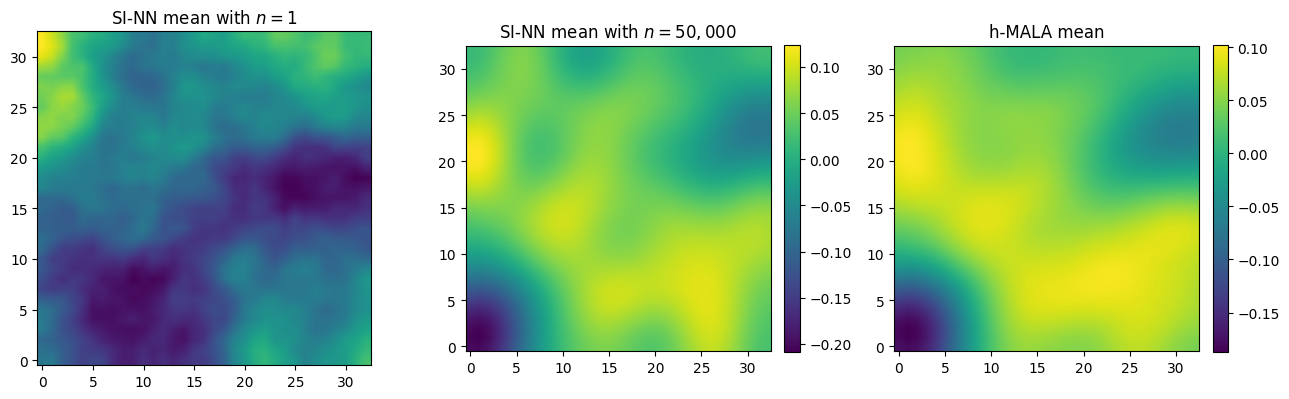

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))
vmin, vmax = -0.15, 0.15

im1 = ax[0].imshow(
    np.mean(u_samps_0, axis=0).reshape(nx, ny), origin="lower", interpolation="bilinear"
)
ax[0].set_title(r"SI-NN mean with $n = 1$")

im2 = ax[1].imshow(
    np.mean(u_samps_1, axis=0).reshape(nx, ny), origin="lower", interpolation="bilinear"
)
ax[1].set_title(r"SI-NN mean with $n = 50,000$")
fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

im3 = ax[2].imshow(
    np.mean(hmala_samps, axis=0).reshape(nx, ny),
    origin="lower",
    interpolation="bilinear",
)
ax[2].set_title(r"h-MALA mean")
fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()

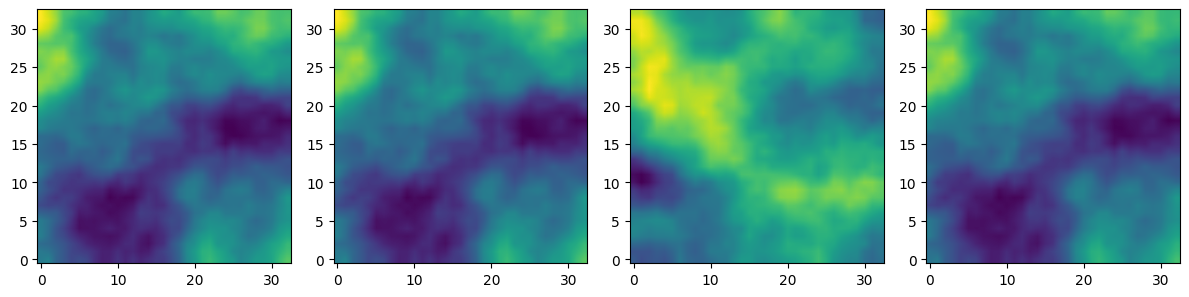

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12, 12))

for i in range(4):
    ax[i].imshow(
        u_samps_0[np.random.choice(nsamps), :, :],
        origin="lower",
        interpolation="bilinear",
    )
plt.tight_layout()

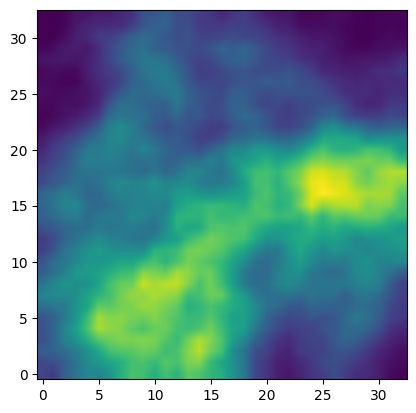

In [45]:
plt.imshow(np.var(u_samps_0, axis=0), origin="lower", interpolation="bilinear")

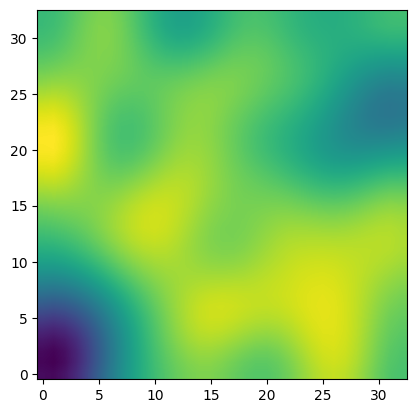

In [46]:
plt.imshow(np.mean(u_samps_1, axis=0), origin="lower", interpolation="bilinear")

In [47]:
mmd_array_nn

array([0.48889387, 0.00132394])